<a href="https://colab.research.google.com/github/franciscoost/Data-Science/blob/master/Analisando_a_Viol%C3%AAncia_no_Rio_de_Janeiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://github.com/franciscoost/Data-Science/blob/master/data/Logo%20Francisco%20Data%20Science%20500px%20X%20500px%20Branco%20s%20fundo.png?raw=true" height="100px"></center>

# Analisando a Violência no Rio de Janeiro

Dentre os diversos desafios que o Brasil enfrenta atualmente, o maior deles certamente é combater a violência. Basta abrirmos qualquer site de notícias para notarmos que as matérias mais frequentes são aquelas que dizem respeito à criminalidade. 

De nada adianta termos uma economia decolando se tivermos medo de sermos assaltados - e no pior dos casos, mortos - ao passear com a família no shopping, por exemplo.

Pensando na transparência das informações públicas, o governo do estado do Rio de Janeiro iniciou o projeto [ISP Dados Abertos](http://www.ispdados.rj.gov.br/). No portal, é possível acessar as bases de dados de registros criminais e de atividade policial do estado. 

Além disso, são disponibilizados arquivos auxiliares com informações relevantes,como [notas metodológicas e dicionários de variáveis](http://www.ispdados.rj.gov.br/Notas.html).

**Neste *notebook*, realizaremos uma análise estatística dos dados históricos disponíveis no portal**

## Obtenção dos Dados


O *dataset* utilizado neste projeto foi obtido através da página [Estatísticas](http://www.ispdados.rj.gov.br/estatistica.html) do ISP Dados Abertos. A base de dados foi elaborada a partir dos Registros de Ocorrência (RO) lavrados nas delegacias da Secretaria de Estado de Polícia Civil do Rio de Janeiro (SEPOL). Além disso, foram utilizadas informações complementares de órgãos específicos da Secretaria de Estado de Polícia Militar do Rio de Janeiro (SEPM). 

Os RO são passam por uma análise do controle de qualidade da Corregedoria Geral da Polícia (CGPOL) da SEPOL do estado, e as os dados levantados baseiam-se na data em que foi confeccionado o Registro de Ocorrência.

Para facilitar a importação e análise dos dados, foi feito um pré-tratamento dos dados, ignorando informações irrelevantes para este estudo. Os dados completos podem ser acessados por [este](http://www.ispdados.rj.gov.br/Arquivos/DOMensalEstadoDesde1991.csv) link. 

### Importando as bibliotecas 

In [0]:
# importar pacotes que serão utilizados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Importando os dados

O arquivo `csv` que utilizaremos baseia-se no disponível pelo portal, e foi coletado em dezembro de 2019. O *dataset* foi salvo no meu [GitHub](https://raw.githubusercontent.com/franciscoost/Data-Science/master/data/violencia_rj_1991.csv) e devemos importá-lo selecionando `;` como separador.

O padrão de um arquivo `csv` é ser separado por vírgula (`,`) mas já que no Brasil utilizamos a vírgula como separador decimal nos números, o `csv` brasileiro é separado por ponto e vírgula  (`;`) 

Também devemos informar que as colunas vazias possuem valores nulos, e para isso basta indicarmos `na_values = " "` na hora de importarmos o arquivo. Isso faz com que os valores vazios agora recebam a definição de NaN (*not a number*)

Vamos continuar importando o arquivo e dando um "oi" para o nosso *dataset*.

In [2]:
# importar o arquivo csv e mostrar as 5 primeiras entradas
df = pd.read_csv("https://raw.githubusercontent.com/franciscoost/Data-Science/master/data/violencia_rj_1991.csv", sep = ";", na_values = " ")

# modificando o index do DataFrame
df = df.set_index(pd.date_range(start = '1/1/1991', freq= 'M', periods=df.shape[0]))

# convertendo a data para exibir somente o ano e o mês
df.index = df.index.strftime('%Y/%m')

# excluindo as colunas vano e mes
df.drop(['vano','mes'], axis=1, inplace=True)

df.head()

,hom_doloso,lesao_corp_morte,latrocinio,hom_por_interv_policial,letalidade_violenta,tentat_hom,lesao_corp_dolosa,estupro,hom_culposo,lesao_corp_culposa,roubo_comercio,roubo_residencia,roubo_veiculo,roubo_carga,roubo_transeunte,roubo_em_coletivo,roubo_banco,roubo_cx_eletronico,roubo_celular,roubo_conducao_saque,roubo_apos_saque,roubo_bicicleta,outros_roubos,total_roubos,furto_veiculos,furto_transeunte,furto_coletivo,furto_celular,furto_bicicleta,outros_furtos,total_furtos,sequestro,extorsao,sequestro_relampago,estelionato,apreensao_drogas,posse_drogas,trafico_drogas,apreensao_drogas_sem_autor,recuperacao_veiculos,apf,aaapai,cmp,cmba,ameaca,pessoas_desaparecidas,encontro_cadaver,encontro_ossada,pol_militares_mortos_serv,pol_civis_mortos_serv,indicador_cvli,indicador_roubo_rua,indicador_roubo_veic,indicador_roubo_carga,registro_ocorrencias,fase
1991/01,657,NaN,15,NaN,672,162,3051,NaN,NaN,NaN,350,188,1174,63,967,381,37,NaN,NaN,NaN,NaN,NaN,158,3318,2009,1147,NaN,NaN,NaN,3561,6717,NaN,NaN,NaN,NaN,133,NaN,NaN,NaN,872,NaN,NaN,NaN,NaN,NaN,NaN,217,NaN,NaN,NaN,NaN,1348,1174,63,NaN,3
1991/02,732,NaN,17,NaN,749,175,3421,NaN,NaN,NaN,357,171,1097,64,963,432,35,NaN,NaN,NaN,NaN,NaN,142,3261,1850,1066,NaN,NaN,NaN,3309,6225,NaN,NaN,NaN,NaN,127,NaN,NaN,NaN,751,NaN,NaN,NaN,NaN,NaN,NaN,209,NaN,NaN,NaN,NaN,1395,1097,64,NaN,3
1991/03,713,NaN,25,NaN,738,216,3613,NaN,NaN,NaN,443,191,1265,71,963,422,43,NaN,NaN,NaN,NaN,NaN,131,3529,2084,1062,NaN,NaN,NaN,3573,6719,NaN,NaN,NaN,NaN,80,NaN,NaN,NaN,789,NaN,NaN,NaN,NaN,NaN,NaN,188,NaN,NaN,NaN,NaN,1385,1265,71,NaN,3
1991/04,634,NaN,20,NaN,654,200,3211,NaN,NaN,NaN,425,199,1415,81,1186,354,36,NaN,NaN,NaN,NaN,NaN,112,3808,2085,1195,NaN,NaN,NaN,3290,6570,NaN,NaN,NaN,NaN,133,NaN,NaN,NaN,787,NaN,NaN,NaN,NaN,NaN,NaN,140,NaN,NaN,NaN,NaN,1540,1415,81,NaN,3
1991/05,650,NaN,20,NaN,670,146,3051,NaN,NaN,NaN,553,231,1449,82,931,335,27,NaN,NaN,NaN,NaN,NaN,147,3755,2185,723,NaN,NaN,NaN,3546,6454,NaN,NaN,NaN,NaN,163,NaN,NaN,NaN,845,NaN,NaN,NaN,NaN,NaN,NaN,78,NaN,NaN,NaN,NaN,1266,1449,82,NaN,3


## Análise Inicial dos Dados


**Dicionário das Variáveis**

Antes de prosseguirmos, devemos entender as variáveis que estamos analisando. A maior parte delas conseguimos compreender pelo nome da coluna. A coluna hom_doloso ou furto_veiculos indica a quantidade de ocorrências do tipo Homicídio Doloso ou Furto de veículos que aconteceram no período. 

Para as colunas `apf`, `cmp` e algumas outras, precisamos verificar o que as siglas significam. Na página [Notas Metodológicas e Dicionários](http://www.ispdados.rj.gov.br/Notas.html), o ISP Dados Abertos fornece arquivos auxiliares que poderemos utilizar na nossa análise.

Para o nosso DataFrame, que indica a quantidade de ocorrências de cada variável para determinado período, utilizaremos o dicionário disponibilizado em arquivo `xlsx`. 

Vamos importar o dicionário e dar uma olhada em suas entradas.

In [3]:
# importar o arquivo do diretório github
df_dic = pd.read_excel("https://github.com/franciscoost/Data-Science/blob/master/data/dicionario_crime_rio.xlsx?raw=true", skiprows = 3, index_col = 0, usecols = [0, 1, 5])

# preencher valores ausentes na coluna Grupo
df_dic["Grupo"].fillna(method = "ffill", inplace=True)
df_dic

,Descrição da variável,Grupo
Variável,,
mes,Mês da comunicação da ocorrência,NaN
vano,Ano da comunicação da ocorrência,NaN
fase,2 - Consolidado sem errata 3 - Consolidado ...,NaN
hom_doloso,Homicídio doloso,VÍTIMAS DE CRIMES VIOLENTOS
lesao_corp_morte,Lesão corporal seguida de morte,VÍTIMAS DE CRIMES VIOLENTOS
latrocinio,Latrocínio (roubo seguido de morte),VÍTIMAS DE CRIMES VIOLENTOS
hom_por_interv_policial,Morte por intervenção de agente do Estado,VÍTIMAS DE CRIMES VIOLENTOS
letalidade_violenta,Letalidade violenta,VÍTIMAS DE CRIMES VIOLENTOS
tentat_hom,Tentativa de homicídio,VÍTIMAS DE CRIMES VIOLENTOS


### **Q1. Quantos atributos (variáveis) e quantas entradas o nosso conjunto de dados possui? Quais os tipos das variáveis?**

Vamos verificar a quantidade de atributos/entradas e quais os tipos das variáveis do nosso dataset.

In [4]:
# identificar o volume de dados do DataFrame
print("Entradas:\t {}".format(df.shape[0]))
print("Variáveis:\t {}\n".format(df.shape[1]))
# verificar o tipo das entradas do dataset
df.dtypes

Entradas:	 347
Variáveis:	 56



hom_doloso                      int64
lesao_corp_morte              float64
latrocinio                      int64
hom_por_interv_policial       float64
letalidade_violenta             int64
tentat_hom                      int64
lesao_corp_dolosa               int64
estupro                       float64
hom_culposo                   float64
lesao_corp_culposa            float64
roubo_comercio                  int64
roubo_residencia                int64
roubo_veiculo                   int64
roubo_carga                     int64
roubo_transeunte                int64
roubo_em_coletivo               int64
roubo_banco                     int64
roubo_cx_eletronico           float64
roubo_celular                 float64
roubo_conducao_saque          float64
roubo_apos_saque              float64
roubo_bicicleta               float64
outros_roubos                   int64
total_roubos                    int64
furto_veiculos                  int64
furto_transeunte                int64
furto_coleti

Agora sim! Podemos prosseguir com a análise.

### **Q2. Qual a porcentagem de valores ausentes no dataset?**


In [5]:
# calculando valores ausentes do DataFrame
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

roubo_bicicleta               0.795389
furto_bicicleta               0.795389
apf                           0.518732
posse_drogas                  0.518732
trafico_drogas                0.518732
apreensao_drogas_sem_autor    0.518732
cmba                          0.518732
cmp                           0.518732
aaapai                        0.518732
furto_coletivo                0.414986
estupro                       0.414986
extorsao                      0.414986
sequestro_relampago           0.414986
estelionato                   0.414986
roubo_apos_saque              0.414986
furto_celular                 0.414986
pol_militares_mortos_serv     0.414986
pol_civis_mortos_serv         0.414986
roubo_cx_eletronico           0.414986
roubo_conducao_saque          0.414986
pessoas_desaparecidas         0.380403
encontro_ossada               0.380403
roubo_celular                 0.311239
ameaca                        0.276657
indicador_cvli                0.276657
sequestro                

Grande parte das variáveis que possuem valores ausentes não eram registradas desde o começo da coleta dos dados da série histórica, janeiro de 1991. Com o passar dos anos, mais variáveis foram sendo adicionadas e controladas.

Apesar disso, os valores nulos não atrapalharão nossa análise. Utilizaremos as variáveis da série histórica de ocorrências criminais de forma isolada.

## Informações Estatísticas da Violência no Rio de Janeiro

Como vimos, temos 347 entradas e 56 variáveis. O dicionário disponibilizado pelo ISP Dados Abertos separa os crimes por grupos. Vamos realizar uma análise estatística de cada um desses grupos e tentar extrair alguma informação relevante.




## Crimes violentos

In [6]:
# filtrar o grupo em um novo DataFrame
df_crime_violento = df[["hom_doloso", "lesao_corp_morte", "latrocinio", "hom_por_interv_policial", "letalidade_violenta", "tentat_hom", "lesao_corp_dolosa", "estupro"]]

# resumo estatístico das variáveis do grupo
df_crime_violento.describe()

,hom_doloso,lesao_corp_morte,latrocinio,hom_por_interv_policial,letalidade_violenta,tentat_hom,lesao_corp_dolosa,estupro
count,347.000000,251.000000,347.000000,263.000000,347.000000,347.000000,347.000000,203.000000
mean,502.936599,4.334661,15.608069,72.741445,576.812680,318.829971,5491.170029,371.556650
std,114.602462,2.742180,5.884902,37.141077,104.956677,127.233468,1508.166253,94.768663
min,272.000000,0.000000,2.000000,10.000000,334.000000,122.000000,2350.000000,188.000000
25%,411.500000,2.000000,11.000000,42.500000,500.000000,200.500000,4135.500000,283.500000
50%,505.000000,4.000000,15.000000,70.000000,589.000000,322.000000,5779.000000,388.000000
75%,577.000000,6.000000,19.000000,97.500000,648.000000,398.000000,6576.000000,442.000000
max,831.000000,21.000000,36.000000,195.000000,848.000000,645.000000,9050.000000,561.000000


Como podemos observar, a linha `count` indica que alguns grupos não possuem registro desde o início. No arquivo completo do dicionário de variáveis disponível na página [Notas Metodológicas e Dicionários](http://www.ispdados.rj.gov.br/Notas.html), existe uma coluna que indica a data de início para cada variável.

Por exemplo, a variável `lesao_corp_morte` começou a ser registrada apenas a partir de 1999, `hom_por_interv_policial` a partir de 1998, e assim por diante. 

Isso explica a variação no resumo de `count` para cada variável.

A maior parte do nosso novo DataFrame parece ter uma média (`mean`) muito próxima da mediana (`median`), mas mesmo assim demonstram valor máximo (`max`) um pouco superior ao terceiro quartil (`75%`). Vamos observar isso num histograma.

### Histograma 

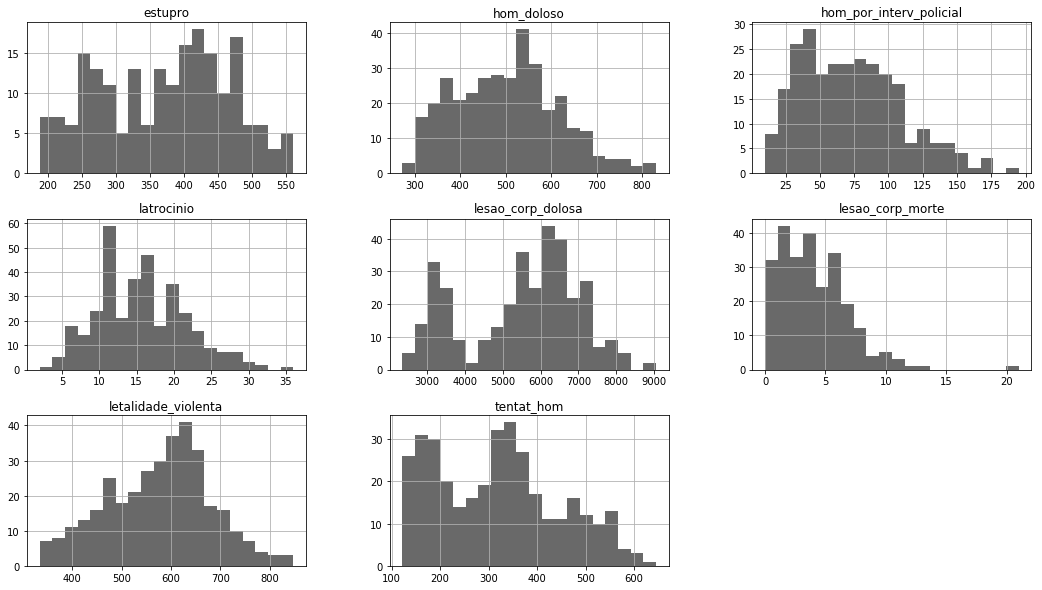

In [7]:
# plotar o histograma
df_crime_violento.hist(bins=20, figsize=(18,10), color="dimgrey");

O gráfico parece bem distribuído, e conforme havíamos antecipado, possuem valores centrados na média. 

Também vale observar que mesmo que as variáveis possuam uma tendência, alguns casos específicos demonstram maior número de ocorrência em alguns períodos.

As ocorrências de `lesao_corp_morte`, por exemplo, são bem distribuídas entre o terceiro quartil (0 a 6 registros) mas também ocorrem casos com mais de 20 registros.


Vamos dar uma olhada na evolução da criminalidade nos últimos anos plotando um gráfico de linhas

### Gráfico de Linhas

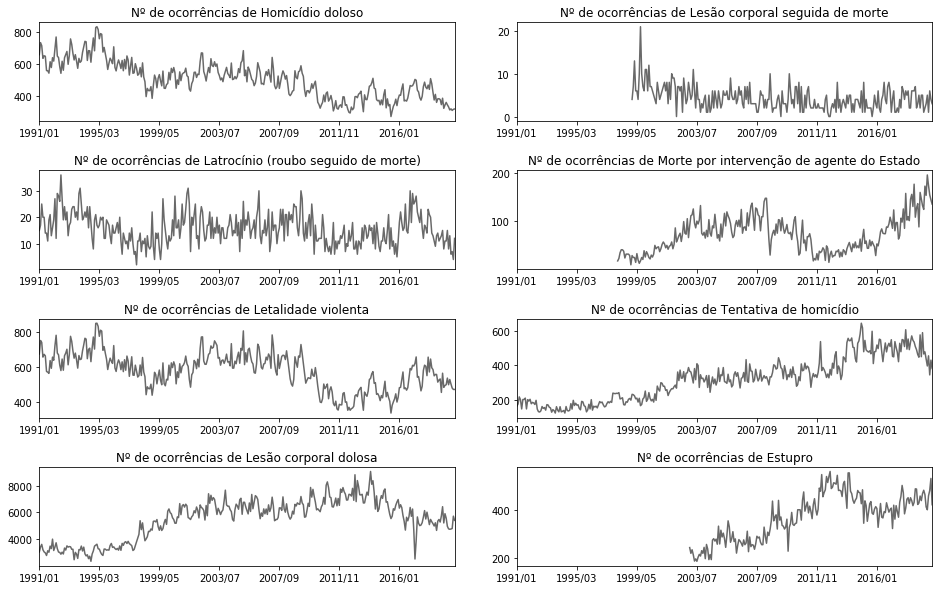

In [8]:
# plotar o gráfico de linhas
lista = ['hom_doloso', 'lesao_corp_morte', 'latrocinio',
       'hom_por_interv_policial', 'letalidade_violenta', 'tentat_hom',
       'lesao_corp_dolosa', 'estupro']
fig = plt.figure(figsize = [16, 10])
fig.subplots_adjust(hspace=0.5, wspace=0.15)
for item in lista:  
  ax = fig.add_subplot(4, 2, lista.index(item)+1)
  df[item].plot(color = "dimgrey")
  ax.set_title('Nº de ocorrências de {}'.format(df_dic['Descrição da variável'][df_dic.index == item].to_string(index=False, header = False).strip()))
plt.show()

O gráfico de linhas nos mostra, dentre outras hipóteses:
* As ocorrências de Homicídio Doloso estão diminuindo com o passar dos anos;
* O número de Latrocínios se manteve constante, com leve queda no final do período;
* As ocorrências de Lesão Corporal seguida de Morte não apresentaram grande variação no período e giraram em torno da média;
* O número de Mortes por intervenção de agente do Estado e casos de Estupro apresentam tendência de crescimento, com crescimento expressivo de 2007 até a atualidade;
* As Tentativas de Homicídio também possuíam tendência de crescimento, mas apresentaram queda no fim do período.

## Crimes de trânsito



In [9]:
# filtrar o grupo em um novo DataFrame
df_crime_transito = df[["hom_culposo", "lesao_corp_culposa"]]

# resumo estatístico das variáveis do grupo
df_crime_transito.describe()

,hom_culposo,lesao_corp_culposa
count,263.000000,251.000000
mean,211.741445,3397.756972
std,54.022275,780.544410
min,111.000000,848.000000
25%,176.000000,3012.000000
50%,203.000000,3358.000000
75%,235.000000,3730.000000
max,449.000000,6653.000000


Quanto às ocorrências relacionadas aos crimes de trânsitos, podemos observar que a média de lesão corporal culposa é de aproximadamente 3400 registros por mês, e a média de homicídio culposo está próxima de 212 casos por mês.

A média e a mediana também são próximas, e assim como no grupo anterior, podemos observar um valor máximo consideravelmente maior que o terceiro quartil.

No caso da variável `hom_culposo`, 75% dos valores estão abaixo de 235 ocorrências mensais, mas o valor máximo é de 449. Para a variável `lesao_corp_culposa`, 75% dos valores estão abaixo de 3730, mas o valor máximo de ocorrências em um período foi de 6653. Isso indica que podem existir picos de ocorrências para esse tipo de crime em determinados períodos.

Vamos observar o histograma deste grupo.

### Histograma 

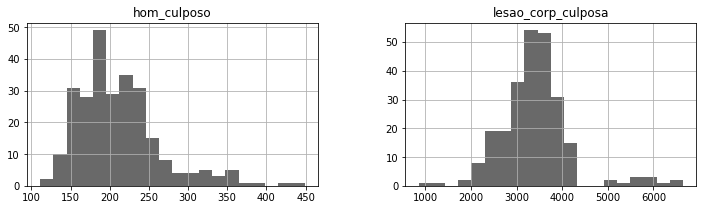

In [10]:
# plotar o histograma
df_crime_transito.hist(bins=20, figsize=(12,3), color="dimgrey");

Novamente o gráfico demonstra ser distribuído em torno da média, mas com alguns períodos de ocorrências elevados.

### Gráfico de Linhas

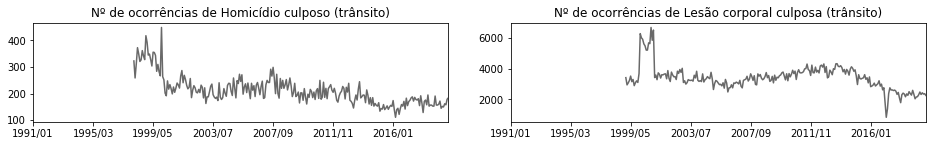

In [11]:
# plotar o gráfico de linhas
lista = ["hom_culposo", "lesao_corp_culposa"]
fig = plt.figure(figsize = [16, 10])
fig.subplots_adjust(hspace=0.5, wspace=0.15)
for item in lista:  
  ax = fig.add_subplot(4, 2, lista.index(item)+1)
  df[item].plot(color = "dimgrey")
  ax.set_title('Nº de ocorrências de {}'.format(df_dic['Descrição da variável'][df_dic.index == item].to_string(index=False, header = False).strip()))
plt.show()

O gráfico nos mostra que ambas as variáveis possuem tendência de queda. Apesar disso, existe um salto no número de ocorrências logo no início do registro dos dados. Também podemos observar uma queda acentuada para as ocorrências de Lesão Corporal Culposa em algum mês após Janeiro/2016. 

## Roubos

In [12]:
# filtrar o grupo em um novo DataFrame
df_roubos = df[["roubo_veiculo", "roubo_carga", "roubo_transeunte", "roubo_em_coletivo", "roubo_banco", "roubo_cx_eletronico", "roubo_celular", "roubo_conducao_saque", "roubo_apos_saque", "roubo_bicicleta", "outros_roubos", "total_roubos"]]

# resumo estatístico das variáveis do grupo
df_roubos.describe()

,roubo_veiculo,roubo_carga,roubo_transeunte,roubo_em_coletivo,roubo_banco,roubo_cx_eletronico,roubo_celular,roubo_conducao_saque,roubo_apos_saque,roubo_bicicleta,outros_roubos,total_roubos
count,347.000000,347.000000,347.000000,347.000000,347.000000,203.000000,239.000000,203.000000,203.000000,71.000000,347.000000,347.000000
mean,2452.363112,341.902017,3439.412104,662.559078,9.296830,3.551724,972.221757,11.275862,144.827586,11.070423,1215.100865,9472.907781
std,787.427549,223.567260,2458.759111,298.795286,10.552433,2.623397,633.196178,6.366898,55.420399,7.726252,798.321870,4583.779568
min,1097.000000,59.000000,688.000000,281.000000,0.000000,0.000000,0.000000,1.000000,11.000000,0.000000,81.000000,3261.000000
25%,1893.500000,210.000000,1055.000000,434.000000,2.000000,2.000000,552.000000,6.000000,103.000000,3.500000,813.500000,5136.500000
50%,2337.000000,287.000000,3018.000000,593.000000,4.000000,3.000000,719.000000,10.000000,149.000000,13.000000,1156.000000,9290.000000
75%,2782.000000,410.000000,5432.000000,786.500000,14.000000,5.000000,1318.000000,15.000000,179.000000,17.000000,1636.500000,11623.500000
max,5358.000000,1329.000000,9669.000000,1628.000000,54.000000,12.000000,2626.000000,37.000000,283.000000,26.000000,3661.000000,23203.000000


Roubo é o tipo de crime caracterizado pela subtração de coisa alheia por meio de violência ou ameaça. Na base de dados do ISP Dados Abertos, o grupo de crimes Roubo é o que possui mais variáveis, tendo até mesmo ocorrência de roubo após saque em bancos. O resumo estatístico do grupo nos mostra que:

* A maior média de ocorrências concentra-se na variável `roubo_transeunte`, com aproximadamente 3440 casos registrados mensalmente
* Novamente, as variáveis apresentam média próxima da mediana, com alguns casos em que a média é um pouco maior que a mediana, e em outros casos o inverso. 
* Para algumas variáveis, como `total_roubo`, o valor máximo é maior que o dobro do terceiro quartil. Isso indica que em alguns casos houveram um salto de ocorrências para certas variáveis em um determinado período, fazendo com que a média superasse consideravelmente a mediana. É o caso das variáveis `roubo_celular`e `roubo_banco`. 

Vamos plotar um histograma para visualizar os dados.

### Histograma 

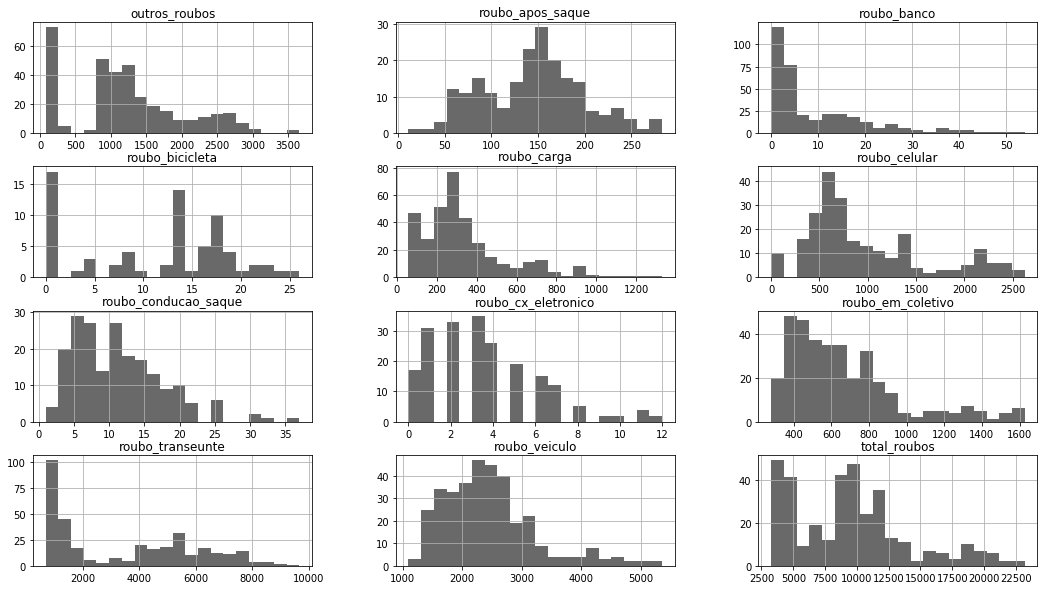

In [13]:
# plotar o histograma
df_roubos.hist(bins=20, figsize=(18,10), color="dimgrey");

Desta vez, além de termos algumas variáveis distribuídas em torno da média, temos muitos casos em que os valores estão concentrados na esquerda. Isso indica que em muitos meses o número de ocorrências é menor, ao mesmo tempo em que em poucos meses as ocorrências elevam consideravelmente, fazendo com que a média não represente fielmente o comportamento de todas as variáveis.

Por exemplo, a variável `roubo_transeunte` possui grande parte dos valores até 2000 casos. Mas sua distribuição nos mostra que alguns meses possuem registros entre 4000 e 6000, e alguns até passam de 8000 ocorrências no mês. Isso faz com que a média seja alta, mesmo que a maior parte dos valores esteja abaixo da média. 

O mesmo ocorre com as variáveis `roubo_banco`, `roubo_celular` e `total_roubos` conforme havíamos dito anteriormente na análise do resumo estatístico. 



### Gráfico de Linhas

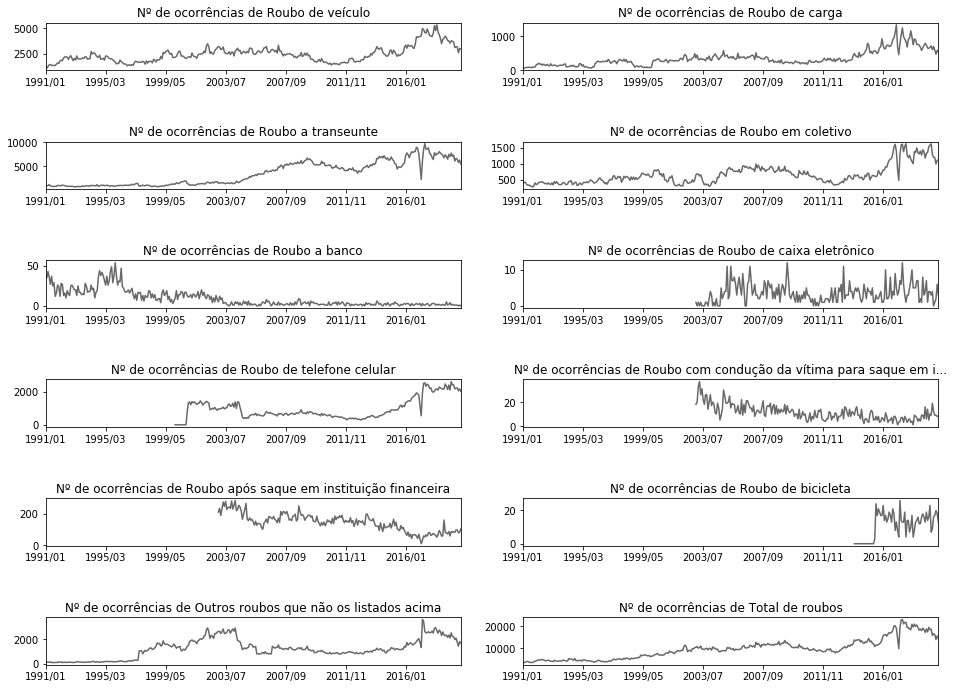

In [14]:
# plotar o gráfico de linhas
lista = ["roubo_veiculo", "roubo_carga", "roubo_transeunte", "roubo_em_coletivo", "roubo_banco", "roubo_cx_eletronico", "roubo_celular", "roubo_conducao_saque", "roubo_apos_saque", "roubo_bicicleta", "outros_roubos", "total_roubos"]
fig = plt.figure(figsize = [16, 14])
fig.subplots_adjust(hspace=1.5, wspace=0.15)
for item in lista:  
  ax = fig.add_subplot(7, 2, lista.index(item)+1)
  df[item].plot(color = "dimgrey")
  ax.set_title('Nº de ocorrências de {}'.format(df_dic['Descrição da variável'][df_dic.index == item].to_string(index=False, header = False).strip()))
plt.show()

Analisando o gráfico, podemos observar que:
* O número de ocorrências de Roubo a banco praticamente estagnou após 2003;
* As demais variáveis do grupo Roubo apresentam aumento considerável, apesar de algumas apresentarem queda no fim do período analisado;
* Para as ocorrências de Roubo de Celular, Roubo em coletivo  , Total de roubos e algumas outras, podemos observar o mesmo comportamento que já notamos em outras variáveis de outros grupos: uma queda acentuada em algum período de 2016.
* A varíavel Roubo de caixa eletrônico apresenta comportamento que varia abruptamente entre um período e outro, possuindo momentos de alta e de queda elevados.


## Furtos

In [15]:
# filtrar o grupo em um novo DataFrame
df_furtos = df[["furto_veiculos", "furto_transeunte", "furto_coletivo", "furto_celular", "furto_bicicleta", "outros_furtos", "total_furtos"]]
# resumo estatístico das variáveis do grupo
df_furtos.describe()

,furto_veiculos,furto_transeunte,furto_coletivo,furto_celular,furto_bicicleta,outros_furtos,total_furtos
count,347.000000,347.000000,203.000000,203.000000,71.000000,347.000000,347.000000
mean,1670.432277,1518.501441,650.123153,1451.546798,129.154930,6004.181556,10449.048991
std,297.073973,967.678948,266.885483,367.215467,81.265816,1959.314185,3685.091194
min,1159.000000,322.000000,23.000000,484.000000,0.000000,2322.000000,4691.000000
25%,1428.500000,737.000000,503.000000,1300.500000,22.000000,3985.000000,6711.000000
50%,1637.000000,1098.000000,715.000000,1488.000000,160.000000,6580.000000,10492.000000
75%,1833.000000,2330.000000,858.500000,1733.500000,183.000000,7592.500000,13864.000000
max,2630.000000,5368.000000,1036.000000,2215.000000,243.000000,9880.000000,18003.000000


Ao contrário do roubo, o furto é o crime caracterizado pela subtração de coisa alheia sem o uso de ameaça ou violência. 

A média para o total de furtos cometidos no período analisado foi de aproxmadamente 10450, e o resumo estatístico para este grupo apresenta as mesmas características que os demais, com média muito parecida com a mediana mas um valor máximo consideravelmente superior ao terceiro quartil.

No resumo estatístico da variável `furto_bicicleta`, podemos notar que temos apenas 71 registros. Os dados disponíveis para essa variável foram coletados apenas a partir de 2015, e por isso teremos poucos valores neste caso.

### Histograma 

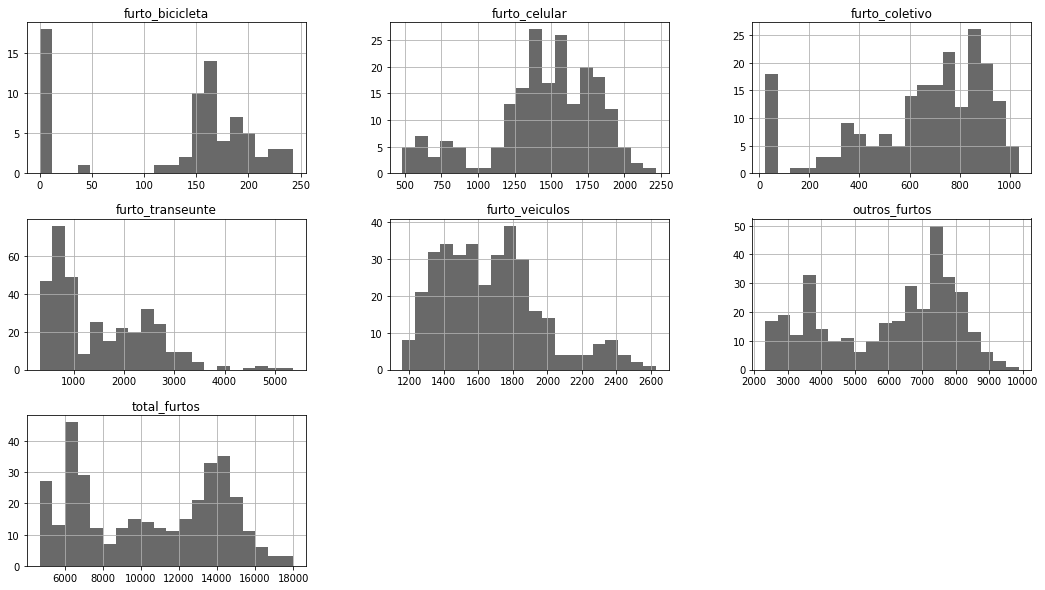

In [16]:
# plotar o histograma
df_furtos.hist(bins=20, figsize=(18,10), color="dimgrey");

Ao analisar os histogramas, podemos verificar que temos variáveis em que:

* A maior parte dos dados concentra-se abaixo da média, com registros esporádicos de aumento nas ocorrências. É o caso das variáveis `furto_transeunte`, `furto_veiculos` e `total_furtos`. 

Mas também temos algumas variáveis em que:

* Os dados estão além da média, registrando mais ocorrências criminais em um maior número de meses. Por exemplo, `furto_coletivo`, `furto_celular` e `outros_furtos`. Para a variável `furto_coletivo`, o resumo estatístico traz que a média é de aproximadamente 650 casos registrados por mês, mas no histograma vemos que grande parte dos dados estão entre 700 e 900 casos no mês.




### Gráfico de Linhas

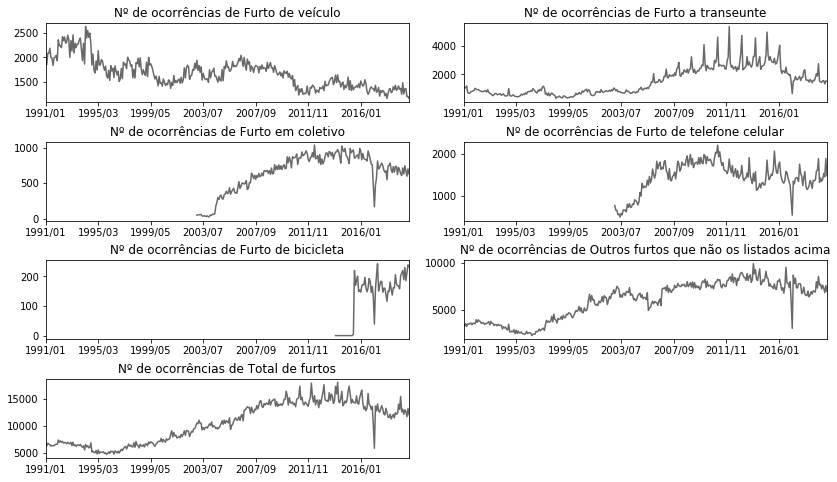

In [17]:
# plotar o gráfico de linhas
lista = ["furto_veiculos", "furto_transeunte", "furto_coletivo", "furto_celular", "furto_bicicleta", "outros_furtos", "total_furtos"]
fig = plt.figure(figsize = [14, 8])
fig.subplots_adjust(hspace=0.5, wspace=0.15)
for item in lista:  
  ax = fig.add_subplot(4, 2, lista.index(item)+1)
  df[item].plot(color = "dimgrey")
  ax.set_title('Nº de ocorrências de {}'.format(df_dic['Descrição da variável'][df_dic.index == item].to_string(index=False, header = False).strip()))
plt.show()

De acordo com o gráfico de linhas, podemos evidenciar as seguintes hipóteses:

* A tendência para ocorrências do tipo Furto de veículo é de queda;
* Furto a transeunte possui alta volatilidade, tendo picos de alta seguidos de quedas abruptas por vários períodos consecutivos, e apesar da tendência de alta, no fim do período apresenta queda;
* Furto de bicicleta, apesar de ter os dados com início de coleta recentemente, apresenta tendência de crescimento;
* Novamente, em algum período de 2016 existe uma queda abrupta para as variáveis do grupo.


## Crimes contra o patrimônio

In [18]:
# filtrar o grupo em um novo DataFrame
df_contra_patrimonio = df[["sequestro", "extorsao", "sequestro_relampago" , "estelionato"]]
# resumo estatístico das variáveis do grupo
df_contra_patrimonio.describe()

,sequestro,extorsao,sequestro_relampago,estelionato
count,251.000000,203.000000,203.000000,203.000000
mean,0.657371,133.384236,7.773399,2255.182266
std,0.956104,43.052698,5.072532,790.896209
min,0.000000,23.000000,0.000000,717.000000
25%,0.000000,110.000000,5.000000,1658.500000
50%,0.000000,133.000000,7.000000,2215.000000
75%,1.000000,152.500000,11.000000,2938.000000
max,5.000000,271.000000,31.000000,4182.000000


Dentre as outras variáveis do grupo, a que mais apresenta números de ocorrência é a variável `estelionato`, com média próxima de 2255 e valor máximo de registros de 4182. 

O grupo segue o que já foi observado anteriormente: a média possui um valor próximo da mediana, com excessão para a variável `sequestro`, que é a que menos possui registros de ocorrência.

### Histograma 

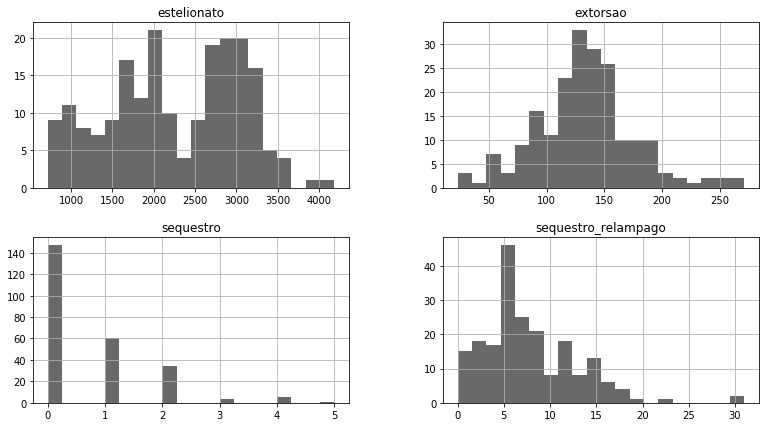

In [19]:
# plotar o histograma
df_contra_patrimonio.hist(bins=20, figsize=(13,7), color="dimgrey");

De acordo com o histograma, podemos inferir que as variáveis não possuem uma distribuição padrão:

* Os casos de estielionato parecem não ter uma distribuição bem definida, com baixas ocorrências próximas a média e muitas ocorrências dispersas;
* Os registros de ocorrência de extrosão estão centrados na média, com poucos casos que existem consideravelmente mais ou menos crimes;
* O gráfico de sequestros está centrado na esquerda, e indica que por muitos períodos não houveram muitos registros, e na maioria dos casos não houveram tantos casos registrados, com 75% dos valores abaixo de 1 ocorrência.
* A variável `sequestro_relampago` possui uma grande quantidade de períodos com poucos registros, mas também houveram alguns poucos períodos em que os casos de sequestro relâmpago elevaram consideravelmente.




### Gráfico de Linhas

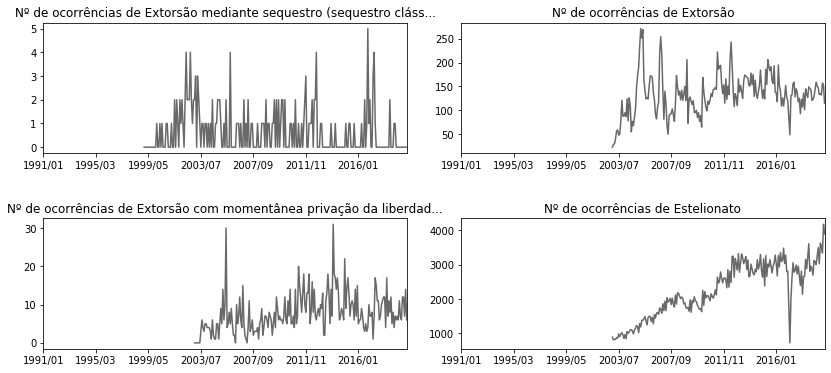

In [20]:
# plotar o gráfico de linhas
lista = ["sequestro", "extorsao", "sequestro_relampago" , "estelionato"]
fig = plt.figure(figsize = [14, 6])
fig.subplots_adjust(hspace=0.5, wspace=0.15)
for item in lista:  
  ax = fig.add_subplot(2, 2, lista.index(item)+1)
  df[item].plot(color = "dimgrey")
  ax.set_title('Nº de ocorrências de {}'.format(df_dic['Descrição da variável'][df_dic.index == item].to_string(index=False, header = False).strip()))
plt.show()

Não é possível traçar uma tendência para todas as variáveis. Para os casos de sequestro, por exemplo, existe uma grande volatilidade nos registros.

A queda abrupta em 2016 também acontece para a maior aprte das variáveis deste grupo, se a única que parece apresentar tendência definida de crescimento é a de estelionato.

## Atividade policial

In [21]:
# filtrar o grupo em um novo DataFrame
df_policial = df[["apreensao_drogas", "posse_drogas", "trafico_drogas", "apreensao_drogas_sem_autor", "recuperacao_veiculos", "apf", "aaapai", "cmp", "cmba"]]
# resumo estatístico das variáveis do grupo
df_policial.describe()

,apreensao_drogas,posse_drogas,trafico_drogas,apreensao_drogas_sem_autor,recuperacao_veiculos,apf,aaapai,cmp,cmba
count,347.000000,167.000000,167.000000,167.000000,347.000000,167.000000,167.000000,167.000000,167.000000
mean,1078.380403,611.604790,762.431138,185.760479,1772.538905,2328.497006,567.275449,1265.239521,86.041916
std,644.338783,244.735238,311.071341,36.013754,653.959789,648.103711,246.031506,361.657250,66.311818
min,80.000000,248.000000,262.000000,114.000000,729.000000,1173.000000,225.000000,628.000000,21.000000
25%,716.000000,364.000000,442.500000,160.000000,1281.000000,1694.000000,333.500000,954.500000,46.000000
50%,981.000000,633.000000,818.000000,183.000000,1764.000000,2434.000000,527.000000,1268.000000,58.000000
75%,1586.500000,764.000000,1045.000000,207.500000,2199.000000,2906.000000,790.000000,1523.000000,94.000000
max,2543.000000,1160.000000,1282.000000,289.000000,3695.000000,3425.000000,1114.000000,2314.000000,350.000000


As variáveis de ocorrências do grupo Atividade policial podem ser separadas igualmente entre aquelas que possuem a média maior que a mediana, e as que possuem a mediana maior que a média. Observa-se que para muitos casos, a diferença entre o terceiro quartil e o valor máximo não é relevante. 

A excessão para isso é a variável Cumprimento Mandado de Prisão, que possui um valor máximo bem superior ao terceiro quartil, o que nos permite inferir que em algum período houve um aumento considerável no número de ocorrências deste tipo de registro.

A variável `recuperacao_veiculos` também apresenta este comportamento, mas neste caso, quanto maior for este valor melhor, pois indica que da quantidade de veículos roubados / furtados, a polícia consegue recuperar alguns deles.

Vamos verificar a porcentagem média de veículos recuperados em relação à quantidade de furtos e roubos de veículos.

In [22]:
print("Média de veículos recuperados: ", ((df.recuperacao_veiculos / (df.furto_veiculos + df.roubo_veiculo))).mean())



Média de veículos recuperados:  0.4233860605839423


Opa! Conseguimos verificar que mais de 42% dos veículos furtados ou roubados são recuperados por ações policiais!

### Histograma 

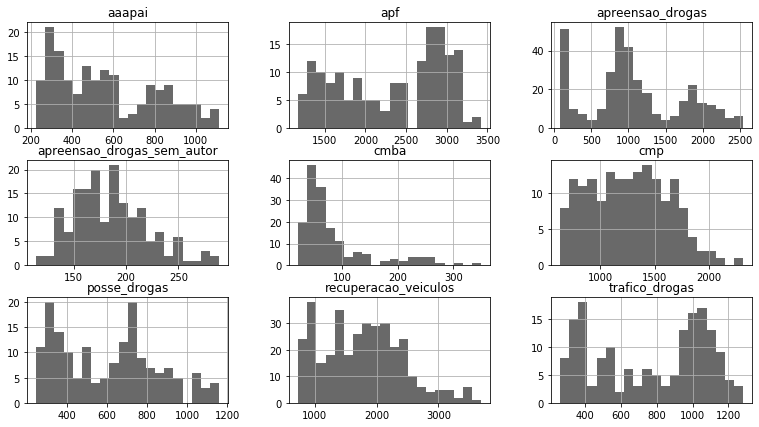

In [23]:
# plotar o histograma
df_policial.hist(bins=20, figsize=(13,7), color="dimgrey");

Para este grupo também não podemos traçar nenhuma tendência geral, mas podemos tentar analisar as variáveis de três maneiras:
* As que possuem distribuição mais à esquerda demonstram não ter muitas ocorrências no período analisado (`aaapai`, `cmba`);
* As que possuem distribuição á direita, demonstram que possuem alto número de ocorrências (`apf`, `trafico_drogas);
* As demais possuem distribuição ao redor da média , como por exemplo `cmp` e `recuperacao_veiculos`




### Gráfico de Linhas

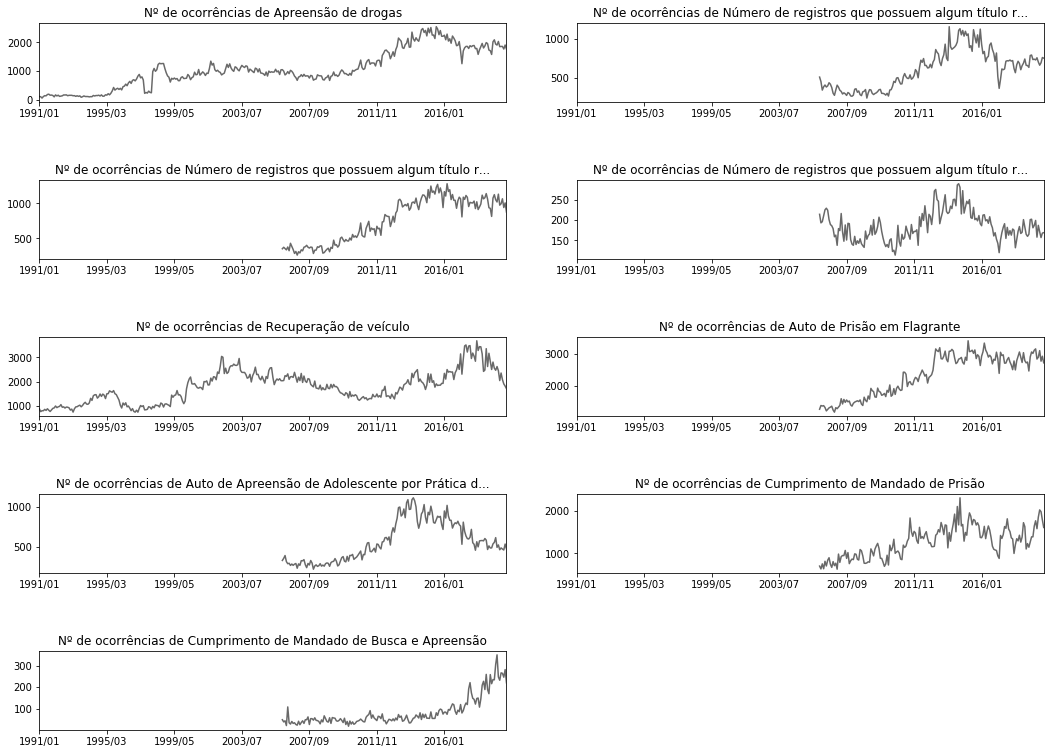

In [24]:
# plotar o gráfico de linhas
lista = ["apreensao_drogas", "posse_drogas", "trafico_drogas", "apreensao_drogas_sem_autor", "recuperacao_veiculos", "apf", "aaapai", "cmp", "cmba"]
fig = plt.figure(figsize = [18, 13])
fig.subplots_adjust(hspace=1, wspace=0.15)
for item in lista:  
  ax = fig.add_subplot(5, 2, lista.index(item)+1)
  df[item].plot(color = "dimgrey")
  ax.set_title('Nº de ocorrências de {}'.format(df_dic['Descrição da variável'][df_dic.index == item].to_string(index=False, header = False).strip()))
plt.show()

O gráfico de linhas nos mostra que todas as variáveis apresentaram aumento em relação à quantidade de ocorrências no início do período.

Recentemente, as variáveis que continuam demonstrando tendência de crescimento são Cumrpimento de Mandado de Busca e Apreensão,  Auto de Prisão em Flagrante e Cumprimento de Mandado de Prisão.

As variáveis que apresentam tendência de queda são Auto de Apreensão de Adolescente por Prática de Ato Infracional, Apreensão de Drogas Sem Autor e Recuperação de Veículos

## Outros Registros

In [25]:
# filtrar o grupo em um novo DataFrame
df_outros = df[["ameaca", "pessoas_desaparecidas", "encontro_cadaver", "encontro_ossada", "pol_militares_mortos_serv", "pol_civis_mortos_serv"]]
# resumo estatístico das variáveis do grupo
df_outros.describe()

,ameaca,pessoas_desaparecidas,encontro_cadaver,encontro_ossada,pol_militares_mortos_serv,pol_civis_mortos_serv
count,251.000000,215.000000,347.000000,215.000000,203.000000,203.000000
mean,5524.151394,434.711628,65.853026,3.339535,2.088670,0.334975
std,1095.826133,65.013159,34.593741,2.277700,1.760968,0.634104
min,1409.000000,236.000000,0.000000,0.000000,0.000000,0.000000
25%,4865.000000,390.000000,41.000000,2.000000,1.000000,0.000000
50%,5443.000000,427.000000,60.000000,3.000000,2.000000,0.000000
75%,6232.000000,481.000000,86.500000,4.000000,3.000000,0.500000
max,9034.000000,628.000000,217.000000,13.000000,10.000000,3.000000


Neste grupo, percebe-se que a variável `ameaca` possui uma quantidade muito superior de ocorrência em relação às demais variáveis do grupo, com uma média de 5524 ocorrências mensais. A variável também possui um valor máximo de 9034 e um terceiro quartil de 6232.

Podemos perceber que as ocorrências em que registra-se morte de policiais militares é superior à de policiais civis. 75% dos períodos possuem até 3 policias militares mortos, enquanto esse valor fica abaixo de 1 para os civis. O máximo de ocorrências para estas variáveis foi de 10 para mortes de policiais militares e 3 para os policiais civis.

Essa observação serve para confirmar o tipo de atuação dos dois tipos de polícia, enquanto a militar atua com vigilância e proteção da lei e da ordem, a polícia civil atua na investigação e repreensão de infrações penais. 

### Histograma 

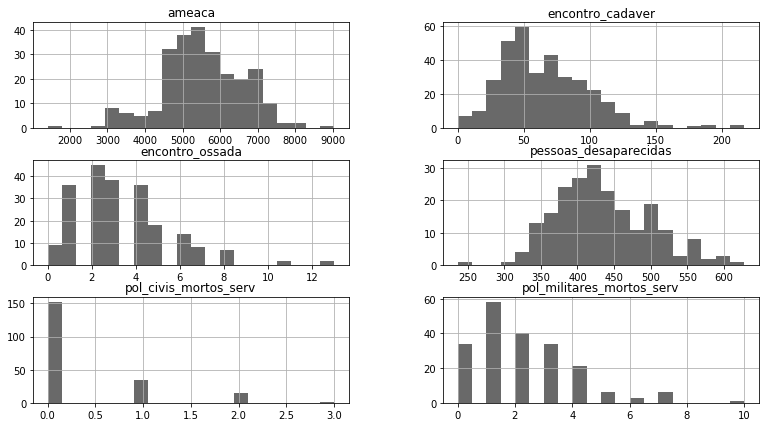

In [26]:
# plotar o histograma
df_outros.hist(bins=20, figsize=(13,7), color="dimgrey");

Confirmando a análise já realizada anteriormente, podemos observar que existem menos registros de mortes de policiais civis do que mortes de policiais militares.

Além disso, observa-se que a variável `pessoas_desaparecidas` possui uma distribuição centrada na média, assim como a variável `ameaca`,  enquanto `encontro_ossada`, `encontro_cadaver` e as mortes de policiais possuem uma distribuição na esquerda, representando menos ocorrências por um maior número de períodos.





### Gráfico de Linhas

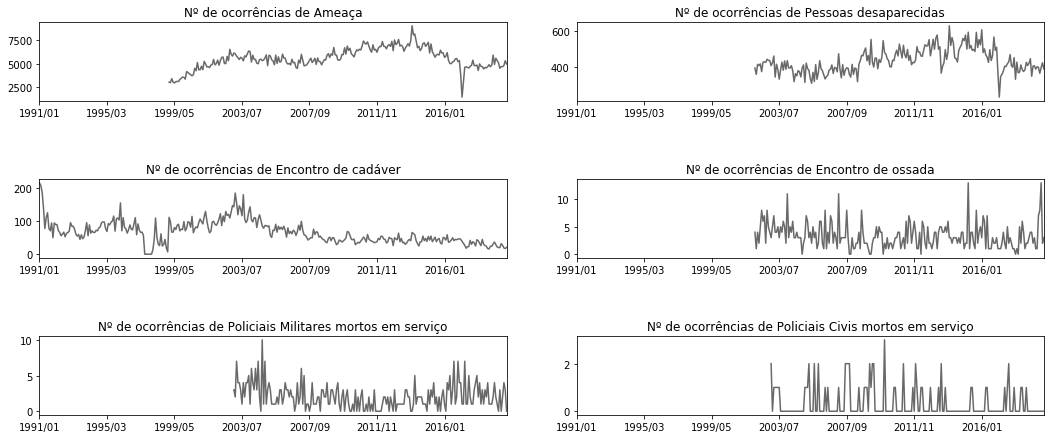

In [27]:
# plotar o gráfico de linhas
lista = ["ameaca", "pessoas_desaparecidas", "encontro_cadaver", "encontro_ossada", "pol_militares_mortos_serv", "pol_civis_mortos_serv"]
fig = plt.figure(figsize = [18, 13])
fig.subplots_adjust(hspace=1, wspace=0.15)
for item in lista:  
  ax = fig.add_subplot(5, 2, lista.index(item)+1)
  df[item].plot(color = "dimgrey")
  ax.set_title('Nº de ocorrências de {}'.format(df_dic['Descrição da variável'][df_dic.index == item].to_string(index=False, header = False).strip()))
plt.show()

Verifica-se que o número de ocorrências do tipo Encontro de cadáver estão em queda desde 2007, enquanto Encontro de Ossada possui uma volatilidade muito acentuada. 

O número de casos de Ameaça e Pessoas desaparecidas vinha caíndo, mas estagnou recentemente.

Essas duas variáveis possuem a mesma queda já observada em 2016.

## Indicadores de Criminalidade e Registro de Ocorrências

In [28]:
# filtrar o grupo em um novo DataFrame
df_indicadores = df[["indicador_cvli", "indicador_roubo_rua", "indicador_roubo_veic", "indicador_roubo_carga", "registro_ocorrencias"]]
# resumo estatístico das variáveis do grupo
df_indicadores.describe()

,indicador_cvli,indicador_roubo_rua,indicador_roubo_veic,indicador_roubo_carga,registro_ocorrencias
count,251.000000,347.000000,347.000000,347.000000,251.000000
mean,477.302789,4771.599424,2452.363112,341.902017,53894.633466
std,91.093117,3214.731194,787.427549,223.567260,11014.469974
min,290.000000,1086.000000,1097.000000,59.000000,30621.000000
25%,398.000000,1568.500000,1893.500000,210.000000,45410.000000
50%,483.000000,4240.000000,2337.000000,287.000000,54971.000000
75%,546.000000,6969.000000,2782.000000,410.000000,63304.000000
max,710.000000,13833.000000,5358.000000,1329.000000,75403.000000


Os grupos de indicadores de criminalidade / registro de ocorrências são elaborados com base nas ocorrências já analisadas anteriormente. Por isso, é normal de se esperar que o resumo estatístico destas variáveis tragam as mesmas observações que já vimos anteriormente:

* Possuem a média próxima da mediana;
* Possuem um valor máximo superiro ao terceiro quartil.

As exceções nesse caso são `indicador_roubo_rua` e `indicador_roubo_carga`, que possuem uma média consideravelmente superior à mediana.





### Histograma 

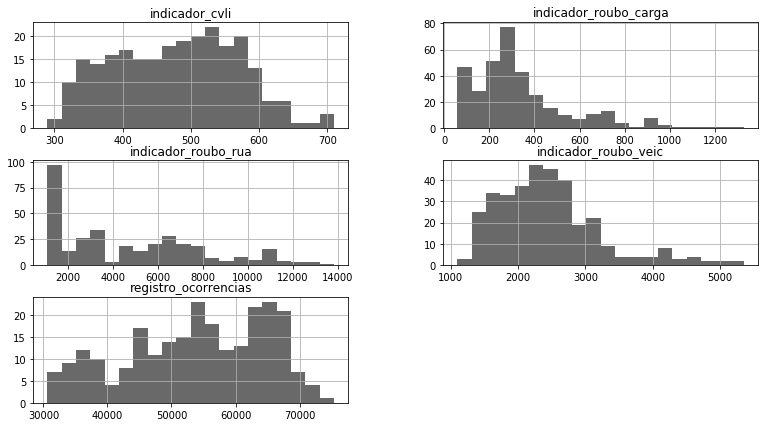

In [29]:
# plotar o histograma
df_indicadores.hist(bins=20, figsize=(13,7), color="dimgrey");

Para as variáveis `indicador_roubo_carga`, `indicador_roubo_rua` e `indicador_roubo_veic`, podemos observar que o histograma está concentrado na esquerda, representando um menor número de ocorrências por um maior número de meses.

As variáveis `indicador_cvli` e `registro_ocorrencias` estão bem distribuídas, mas com tendência à direita, tendo de certa forma o comportamento oposto comparado com as demais variáveis do grupo. 




### Gráfico de Linhas

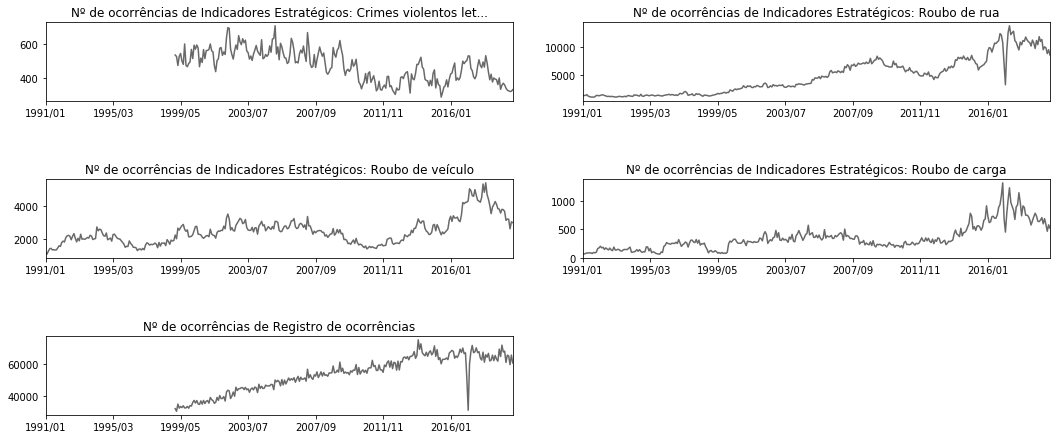

In [30]:
# plotar o gráfico de linhas
lista = ["indicador_cvli", "indicador_roubo_rua", "indicador_roubo_veic", "indicador_roubo_carga", "registro_ocorrencias"]
fig = plt.figure(figsize = [18, 13])
fig.subplots_adjust(hspace=1, wspace=0.15)
for item in lista:  
  ax = fig.add_subplot(5, 2, lista.index(item)+1)
  df[item].plot(color = "dimgrey")
  ax.set_title('Nº de ocorrências de {}'.format(df_dic['Descrição da variável'][df_dic.index == item].to_string(index=False, header = False).strip()))
plt.show()

Com relação aos gráficos, podemos observar: 

* Os Indicadores Estratégicos de Crimes violentos letais intencionais, de Roubo de Rua, Roubo de Veículo e Roubo de carga apresentam um comportamentoe de queda no fim do período, mesmo que tenham crescido em algum momento anteriormente.
* Os Registros de ocorrências possuem tendência de crescimento bem evidente, e novamente fica claro a queda brusca em 2016.



## Conclusão

Concluída a análise estatística da série histórica de ocorrências registradas disponibilizada pelo Instituto de Segurança Pública do estado do Rio de Janeiro, ainda nos resta uma dúvida:

* O que motivou a queda abrupta de diversas variáveis do conjunto de dados em 2016?

Em janeiro de 2017, policiais civis do Rio de Janeiro [iniciam paralização geral](https://g1.globo.com/rio-de-janeiro/noticia/policiais-civis-do-rj-fazem-paralisacao-diz-sindicato.ghtml), e neste período apenas casos graves eram registrados (homicídio, estupro, sequestro). 

Por isso, a queda após 2016 não foi resultado de melhoria na segurança, efeito de alguma política pública ou coisa do tipo. O motivo foi justamente a [crise na segurança pública que o estado do RJ estava vivenciando](https://noticias.r7.com/rio-de-janeiro/seguranca-publica-vive-crise-no-rio-30072017).

Sobre nosso conjunto de dados, podemos concluir:

* O volume de dados é bem alto, e é estruturado de maneira que permite a análise estatística de diversas formas;
* O dicionário facilita ainda mais essa análise e colabora com a transparência dos dados;
* Não existe um padrão para todas as variáveis. Existem tendências diferentes para cada grupo, com variáveis que possuem diferenças entre si;
* Algumas variáveis possuem tendência à esquerda, com menores ocorrências por mais períodos, e outras com tendência à direita, onde ocorria justamente o contrário. Outras possuíam uma distribuição bem visível; 
* Apesar das diferenças, o conjunto de dados apresentou, no geral, média muito próxima da mediana, e valor máximo bem superior ao terceiro quartil;
* Foi possível observar a diferença nas áreas de atuação da polícia civil e da polícia militar;
* Muitas variáveis apresentaram queda no final do período, evidenciando uma melhoria na situação do estado.

O objetivo desta análise foi verificar algumas estatísticas e tendências para as variáveis do conjunto de dados disponibilizado pelo ISP Dados Abertos, e a queda generalizada motivada pela greve dos policiais civis nos ensina a importância de se analisar os dados estatisticamente de diversas maneiras.